# Contributors
Zijian Zhang 14851598 $\\$
Amish Sewlal 13297503 $\\$
Ravi Sharma Kaushik 14332744

# Creating Mandlebrot Set

# Area of Mandlebrot Set using Monte Carlo Method

# Convergence studies for various number of iterations and samples

# Using varous sampling techniques  

# Approach for improving convergence

In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from Mandelbrot_h import whenLeaveMandelbrotSet as wlms, orthogonalSampling_h as OS_h
from MonteCarloIntegration import orthogonalSampling as OS
from QuasiMonteCarlo import quasiMC
import scipy.stats.qmc as qmc

#### Circle sampling

In [185]:
def RS_circle(iter_num: int, s_num: int, R: int = 2) -> np.ndarray:
    '''Compute the area of the Mandelbrot set by pure random sampling within a circle.
    Parameters:
        iter_num: the number of iterations (i)
        s_num: the number of samples (s)
        R: the radius of the circle
    Returns:
        A_h: the areas of the Mandelbrot set during the run
    '''
    history = np.zeros((s_num, iter_num))
    # history is the historical data for all samples at each step in the iteration
    for s in range(s_num):
        U1 = np.random.uniform(0, 1)
        U2 = np.random.uniform(0, 1)
        theta = U1 * 2 * math.pi
        r = R * math.sqrt(U2)
        real = r * math.cos(theta)
        imag = r * math.sin(theta)
        c = complex(real, imag)
        j = wlms(c, iter_num)
        # j is the iteration number when c leave the Mandelbrot set
        # If c never leave the Mandelbrot set, j = iter_num
        history[s, :j] = 1

    # Compute the area of the Mandelbrot set
    N_h = history.sum(axis=0)
    # N_h is the number of samples that are in the Mandelbrot set during the run
    A_total = math.pi * R**2  # The area of the sampling region
    A_h = N_h / s_num * A_total

    return A_h


def LHS_circle(iter_num: int, s_num: int, R: int = 2) -> np.ndarray:
    '''Compute the area of the Mandelbrot set by Latin hypercube sampling within a circle.
    Parameters:
        iter_num: the number of iterations (i)
        s_num: the number of samples (s)
        R: the radius of the circle
    Returns:
        A_h: the areas of the Mandelbrot set during the run
    '''
    idx = np.arange(s_num)
    np.random.shuffle(idx)
    history = np.zeros((s_num, iter_num))
    # history is the historical data for all samples at each step in the iteration
    for s in range(s_num):
        U1 = np.random.uniform(0, 1)
        U2 = np.random.uniform(0, 1)
        # Split the circular sampling region into s sectors, and get the RV: theta
        theta = 2 * math.pi * (s + U1) / s_num
        # Divide the sector into s equal parts of equal area, and get the RV: r
        r = R * math.sqrt((idx[s] + U2) / s_num)
        real = r * math.cos(theta)
        imag = r * math.sin(theta)
        c = complex(real, imag)
        j = wlms(c, iter_num)
        # j is the iteration number when c leave the Mandelbrot set
        # If c never leave the Mandelbrot set, j = iter_num
        history[s, :j] = 1

    # Compute the areas of the Mandelbrot set during the run
    N_h = history.sum(axis=0)
    # N_h is the number of samples that are in the Mandelbrot set during the run
    A_total = math.pi * R**2  # The area of the sampling region
    A_h = N_h / s_num * A_total

    return A_h


def OS_circle(iter_num: int, s_num: int, R: int = 2) -> np.ndarray:
    '''Compute the area of the Mandelbrot set by orthogonal sampling within a circle.
    Parameters:
        iter_num: the number of iterations (i)
        s_num: the number of samples (s)
        R: the radius of the circle
    Returns:
        A_h: the areas of the Mandelbrot set during the run
    '''
    # Radius of the sampling region
    R = 2

    # Samples has to be a perfect square
    sqr = int(np.floor(np.sqrt(s_num)))
    s_num = sqr**2

    # Create array with minor sectors
    sectors = np.linspace(0, 2 * math.pi, s_num)

    # Randomly shuffle minor sectors
    np.random.shuffle(sectors)

    # Creating major rings
    rings = R * np.sqrt(np.linspace(0, 1, s_num + 1))

    # Creating the historical data for all samples at each step in the iteration
    history = np.zeros((s_num, iter_num))

    # Looping through each major ring
    for i in range(sqr):
        # Creating array with minor rings in current
        low = i * sqr
        high = (i + 1) * sqr
        minor_rings = rings[low:high]

        # Shuffling minor rings
        np.random.shuffle(minor_rings)

        # Looping through each minor ring
        for j in range(sqr):
            # Creating complex number
            s = sqr * i + j
            theta = sectors[s]
            l = minor_rings[j]
            real = l * math.cos(theta)
            imag = l * math.sin(theta)
            c = complex(real, imag)

            # Adding to mandelbrot
            # j is the iteration number when c leave the Mandelbrot set
            # If c never leave the Mandelbrot set, j = iter_num
            j = wlms(c, iter_num)
            history[s, :j] = 1

    # Computing the number of samples that are in the Mandelbrot set during the run
    N_h = history.sum(axis=0)

    # Computing the area of the sampling region
    A_total = math.pi * R**2

    # Computing the areas during the run
    A_h = N_h / s_num * A_total

    return A_h

The first j that achieves the expect accuracy:
OS: 220
OSC: 240


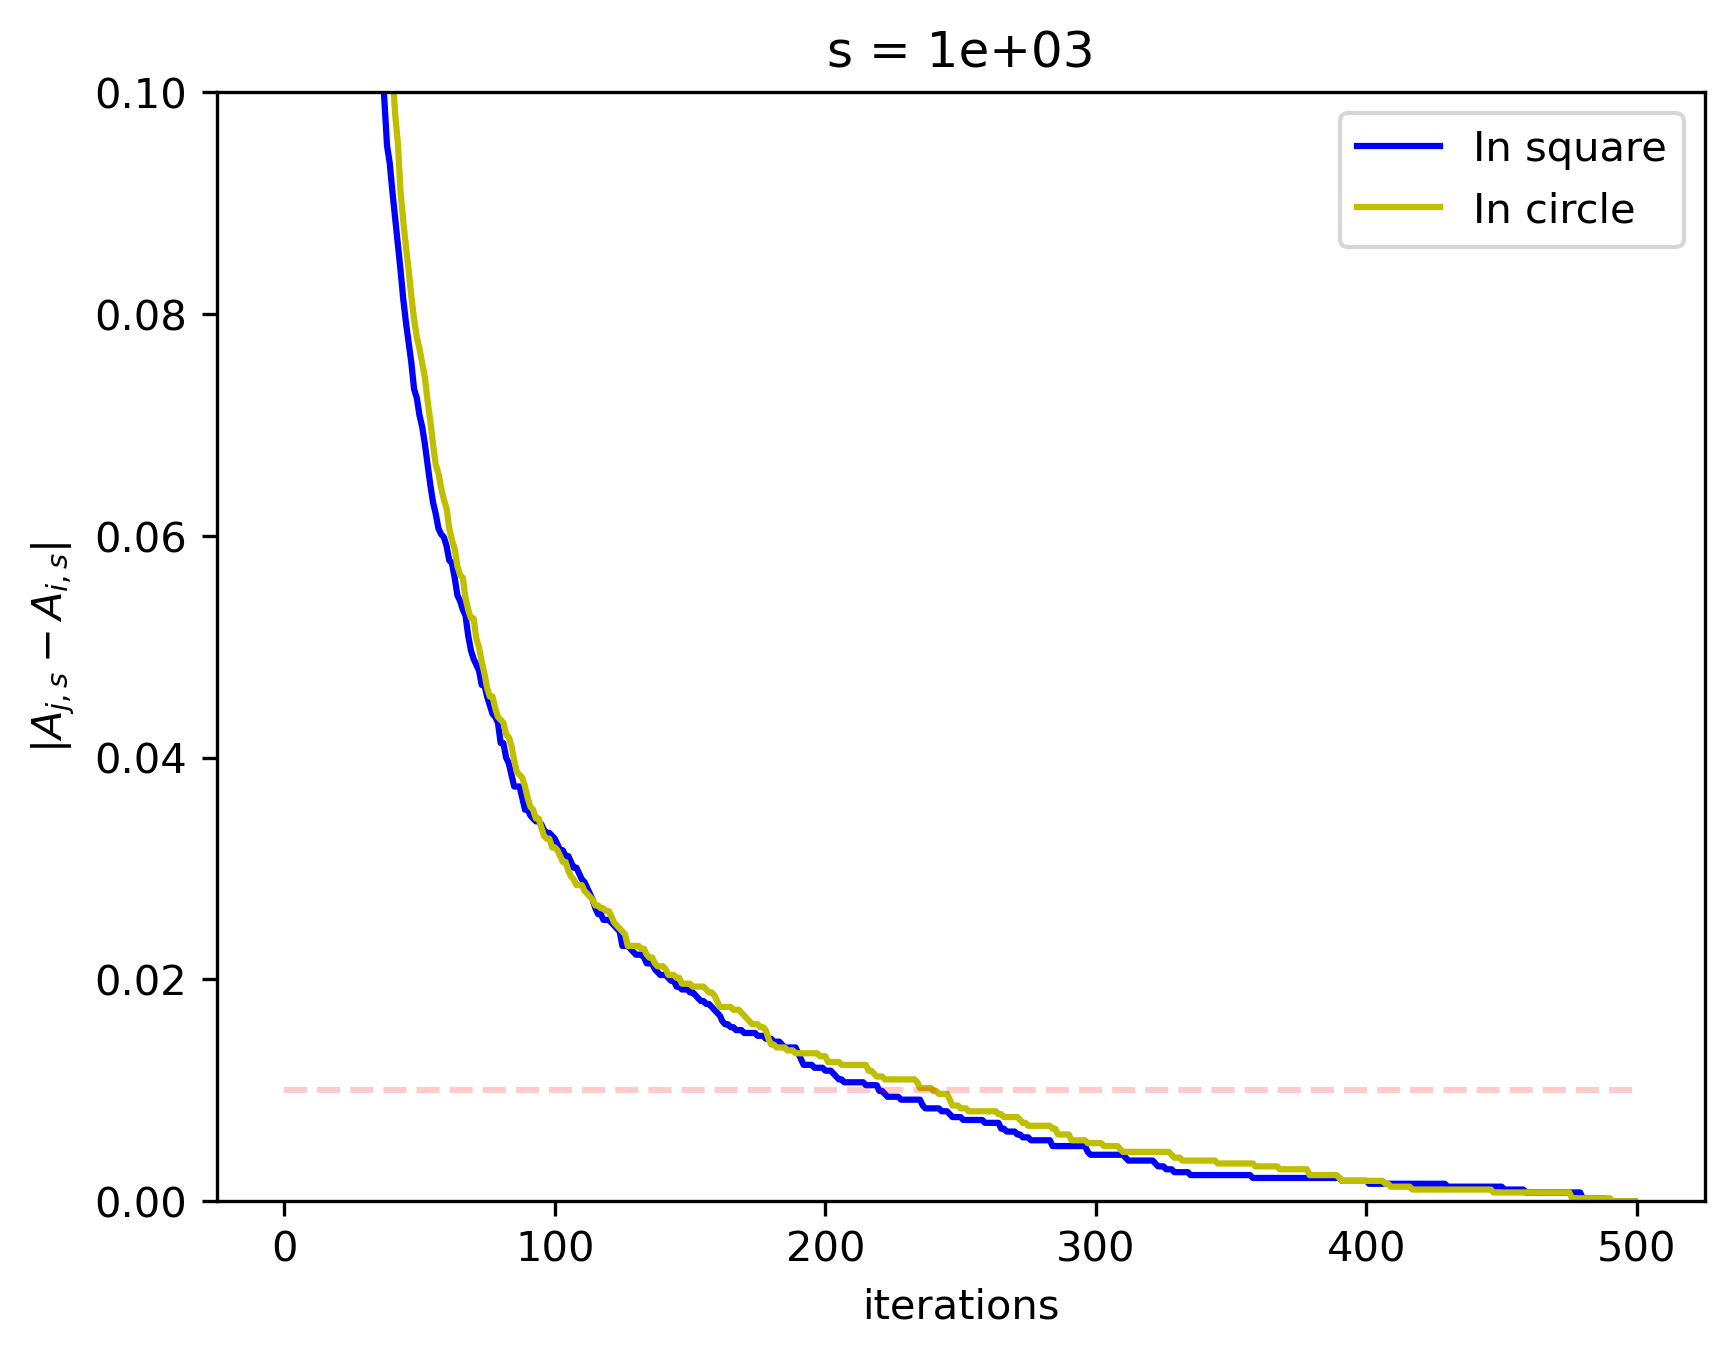

In [186]:
# Compare the convergence rate of the two orthogonal methods with constant s
i = 500  # Max iterations
s = 1000  # s is constant
x = np.arange(i)
l = np.sqrt(4 * math.pi) / 2  # Make the sampling area the same size

# 1 for in square, 2 for in circle
y1, y2 = [], []
for k in range(50):
    A_h1 = OS_h(-l, l, i, s)
    A_h2 = OS_circle(i, s, R=2)
    y1.append(np.abs(A_h1 - A_h1[-1]))
    y2.append(np.abs(A_h2 - A_h2[-1]))
mean1 = np.mean(y1, axis=0)
mean2 = np.mean(y2, axis=0)

print("The first j that achieves the expect accuracy:")
expect_acc = 0.01  # Expected accuracy
print("OS:", np.where(mean1 <= expect_acc)[0][0])
print("OSC:", np.where(mean2 <= expect_acc)[0][0])

plt.figure(dpi=300)
plt.plot(x, mean1, label="In square", c='b')
plt.plot(x, mean2, label="In circle", c='y')
plt.hlines(expect_acc, 0, i, linestyle='dashed', color='red', alpha=0.2)
plt.xlabel("iterations")
plt.ylabel(r"$|A_{j,s}-A_{i,s}|$")
plt.title("s = {:.0e}".format(s))
plt.ylim(0, 0.1)
plt.legend()
plt.show()

#### Quasi random sampling

Constant i, varying s

QMC: 81


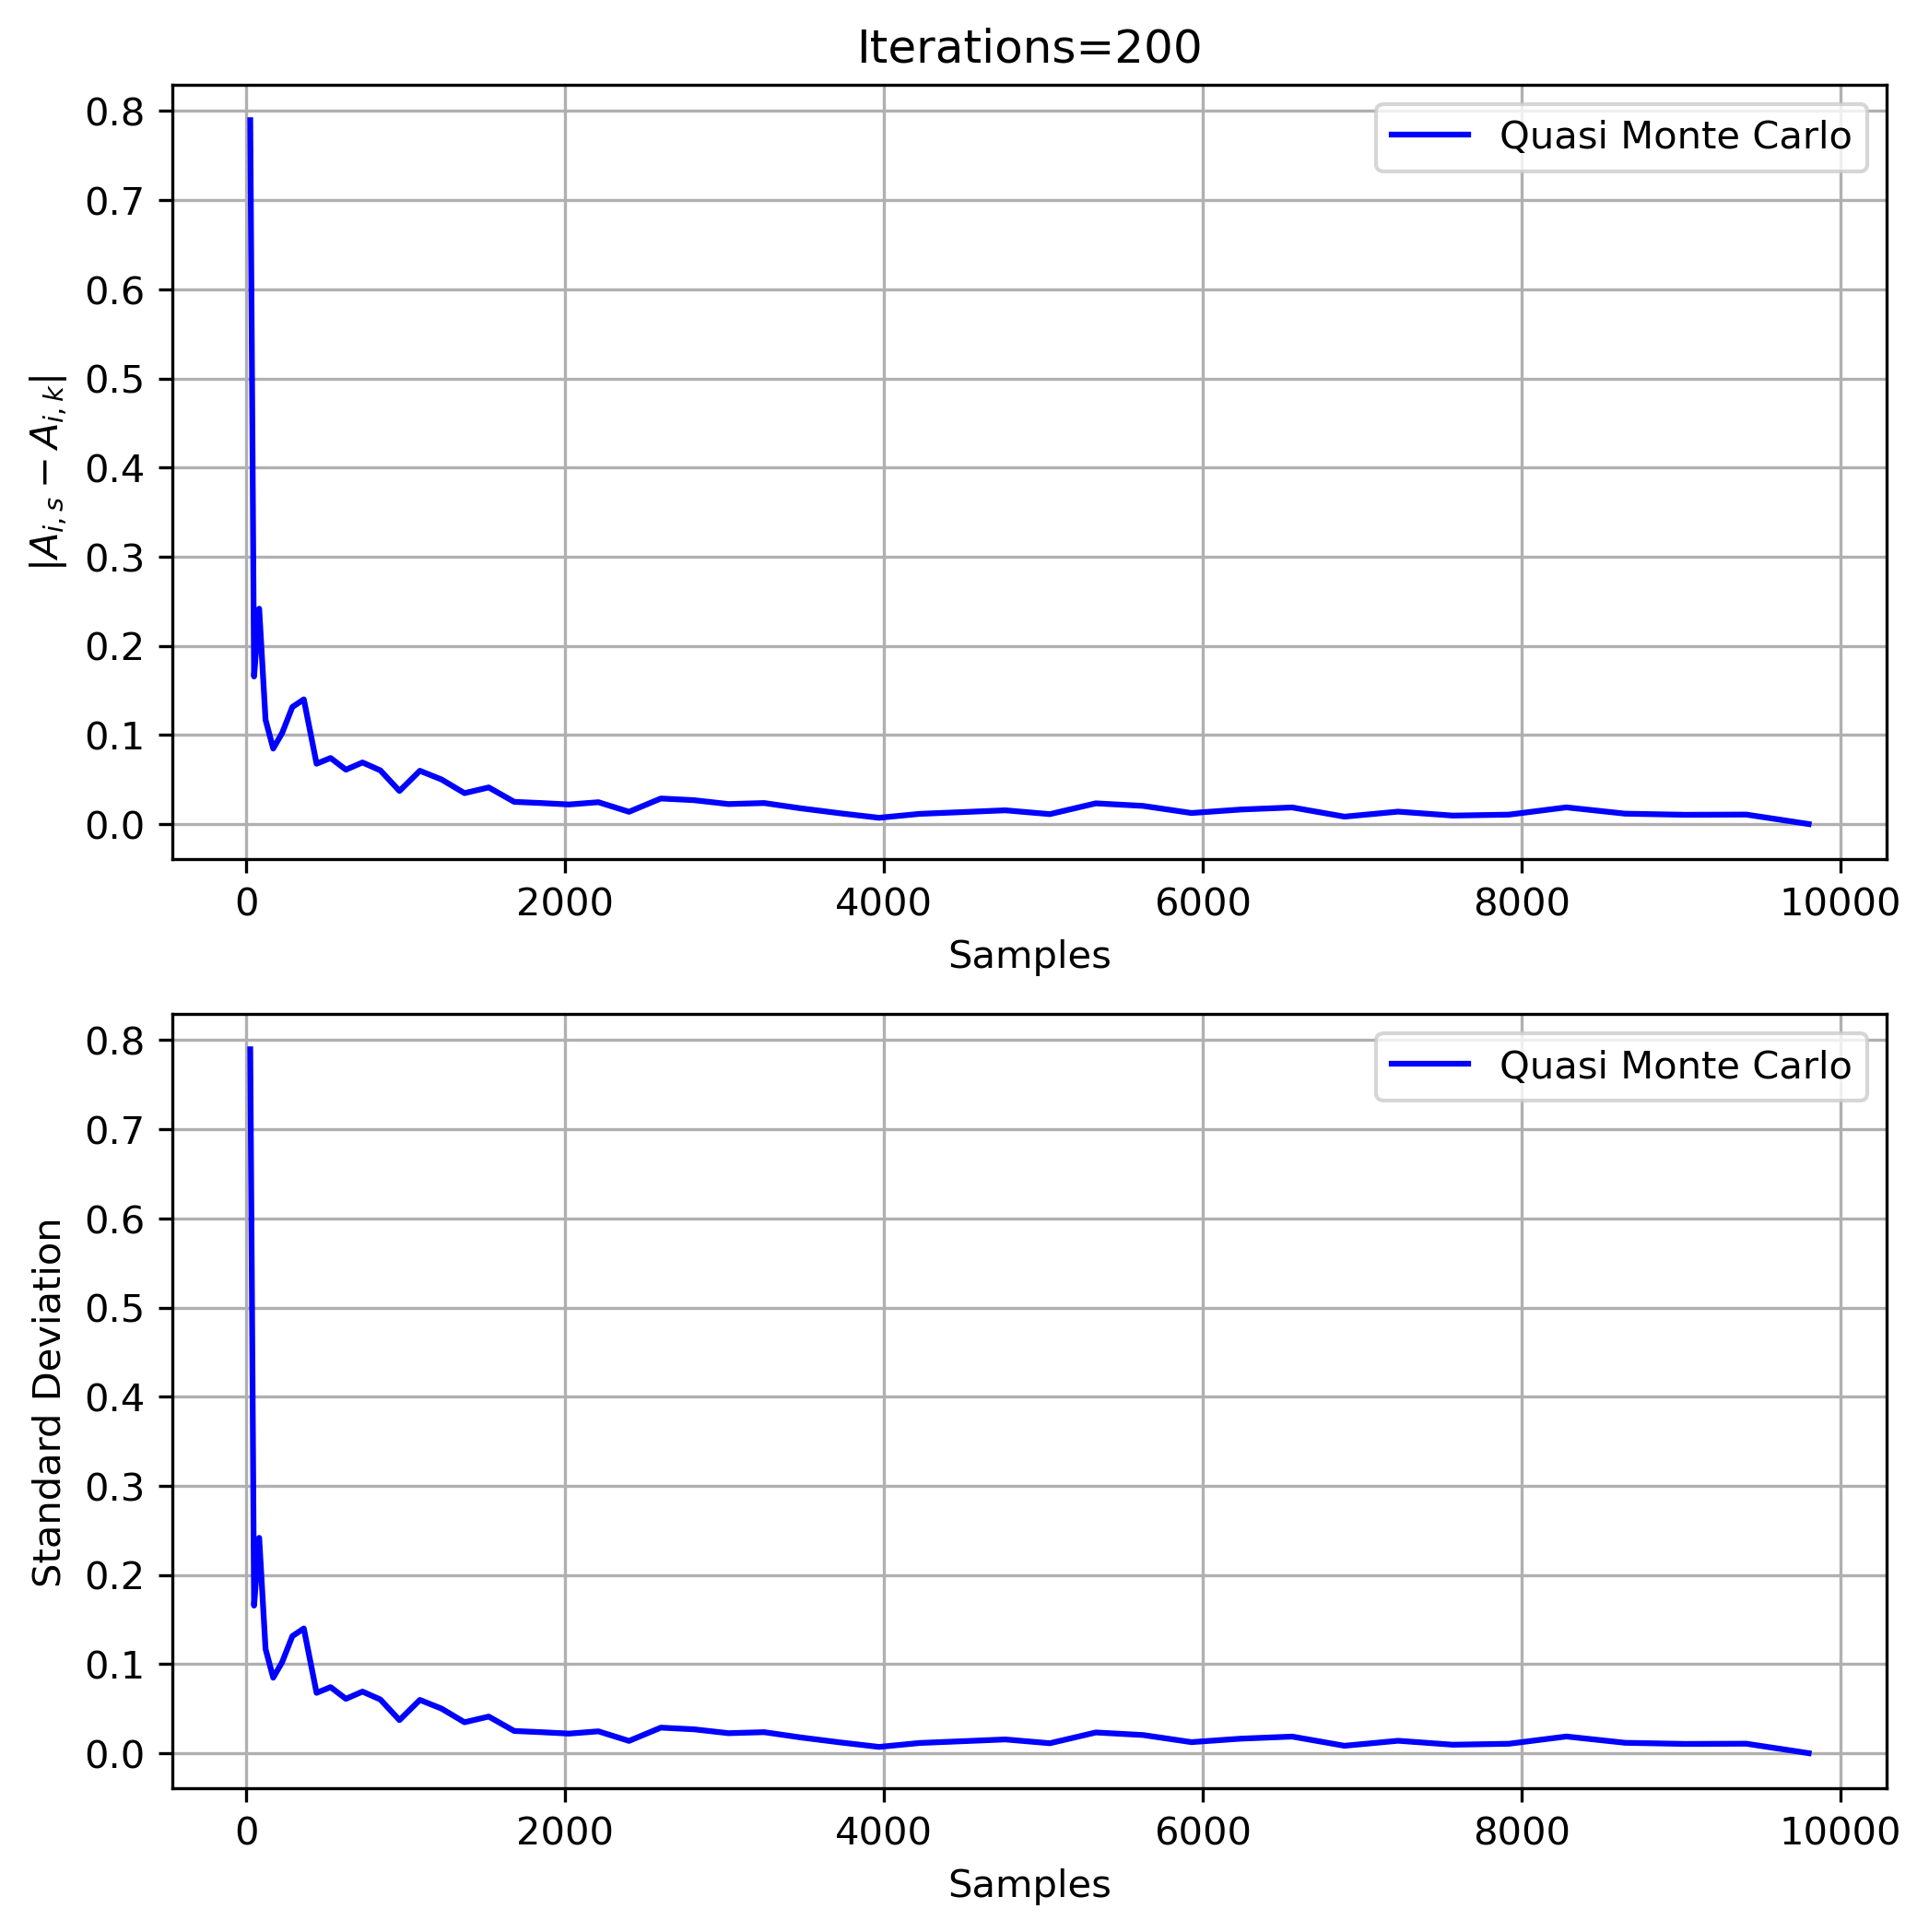

In [186]:
# Get the data
i = 200  # iteration number
run_num = 5  # number of runs at each "s"
s_list = np.arange(5, 101, 2)
s_list = s_list**2  # list of "s"
data_QMC = np.zeros((len(s_list), run_num))
for j, s in enumerate(s_list):  # row: different s values
    for k in range(run_num):  # column: different runs
        data_QMC[j, k] = quasiMC(-2, 2, i, s)  # areas per run
deltaA_QMC = np.abs(data_QMC - data_QMC[-1, :])  # area difference

# Get the convergence iteration number
significance_level = 0.05
conv_i_QMC = 0
for s, deltaA in zip(s_list, deltaA_QMC):
    _, p_value = stats.ttest_ind(deltaA, deltaA_QMC[-1], equal_var=False)
    if p_value > significance_level:
        conv_i_QMC = s
        break
print("QMC:", conv_i_QMC)

# Prepare for plotting
std_QMC = np.std(deltaA_QMC, axis=1)
mean_QMC = np.mean(deltaA_QMC, axis=1)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(8, 8), dpi=300)
axes[0].set_title(f"Iterations={i}")
axes[0].set_xlabel("Samples")
axes[0].set_ylabel("$|A_{i,s}-A_{i,k}|$")
axes[0].plot(s_list, mean_QMC, label='Quasi Monte Carlo', c='b')
axes[0].grid()
axes[0].legend()
axes[1].set_xlabel("Samples")
axes[1].set_ylabel("Standard Deviation")
axes[1].plot(s_list, mean_QMC, label='Quasi Monte Carlo', c='b')
axes[1].grid()
axes[1].legend()
plt.show()

Constant s, varying i

In [94]:
# constant s, varying i
i_start, i_end, i_step = 10, 200, 10
i_s = range(i_start, i_end + i_step, i_step)
s = 500
mean_OS, mean_QMC = [], []
std_OS, std_QMC = [], []
for i in i_s:
    As_OS, As_QMC = [], []
    for j in range(100):
        As_OS.append(OS(-2, 2, i, s))
        As_QMC.append(quasiMC(-2, 2, i, s))
    mean_OS.append(np.mean(As_OS))
    mean_QMC.append(np.mean(As_QMC))
    std_OS.append(np.std(As_OS))
    std_QMC.append(np.std(As_QMC))

In [104]:
# Get the number of iterations it took to reach the expected accuracy
mean_OS = np.array(mean_OS)
mean_QMC = np.array(mean_QMC)
std_OS = np.array(std_OS)
std_QMC = np.array(std_QMC)
deltaA_OS = np.abs(mean_OS - mean_OS[-1])
deltaA_QMC = np.abs(mean_QMC - mean_QMC[-1])
expected_accuracy = 0.01
i1 = np.where(deltaA_OS < expected_accuracy)[0][0]
i2 = np.where(deltaA_QMC < expected_accuracy)[0][0]
print("The number of iterations it took to reach the expected accuracy:")
print("Orthogonal Sampling:", i1)
print("Quasi Monte Carlo:", i2)


The number of iterations it took to reach the expected accuracy:
Orthogonal Sampling: 19
Quasi Monte Carlo: 12


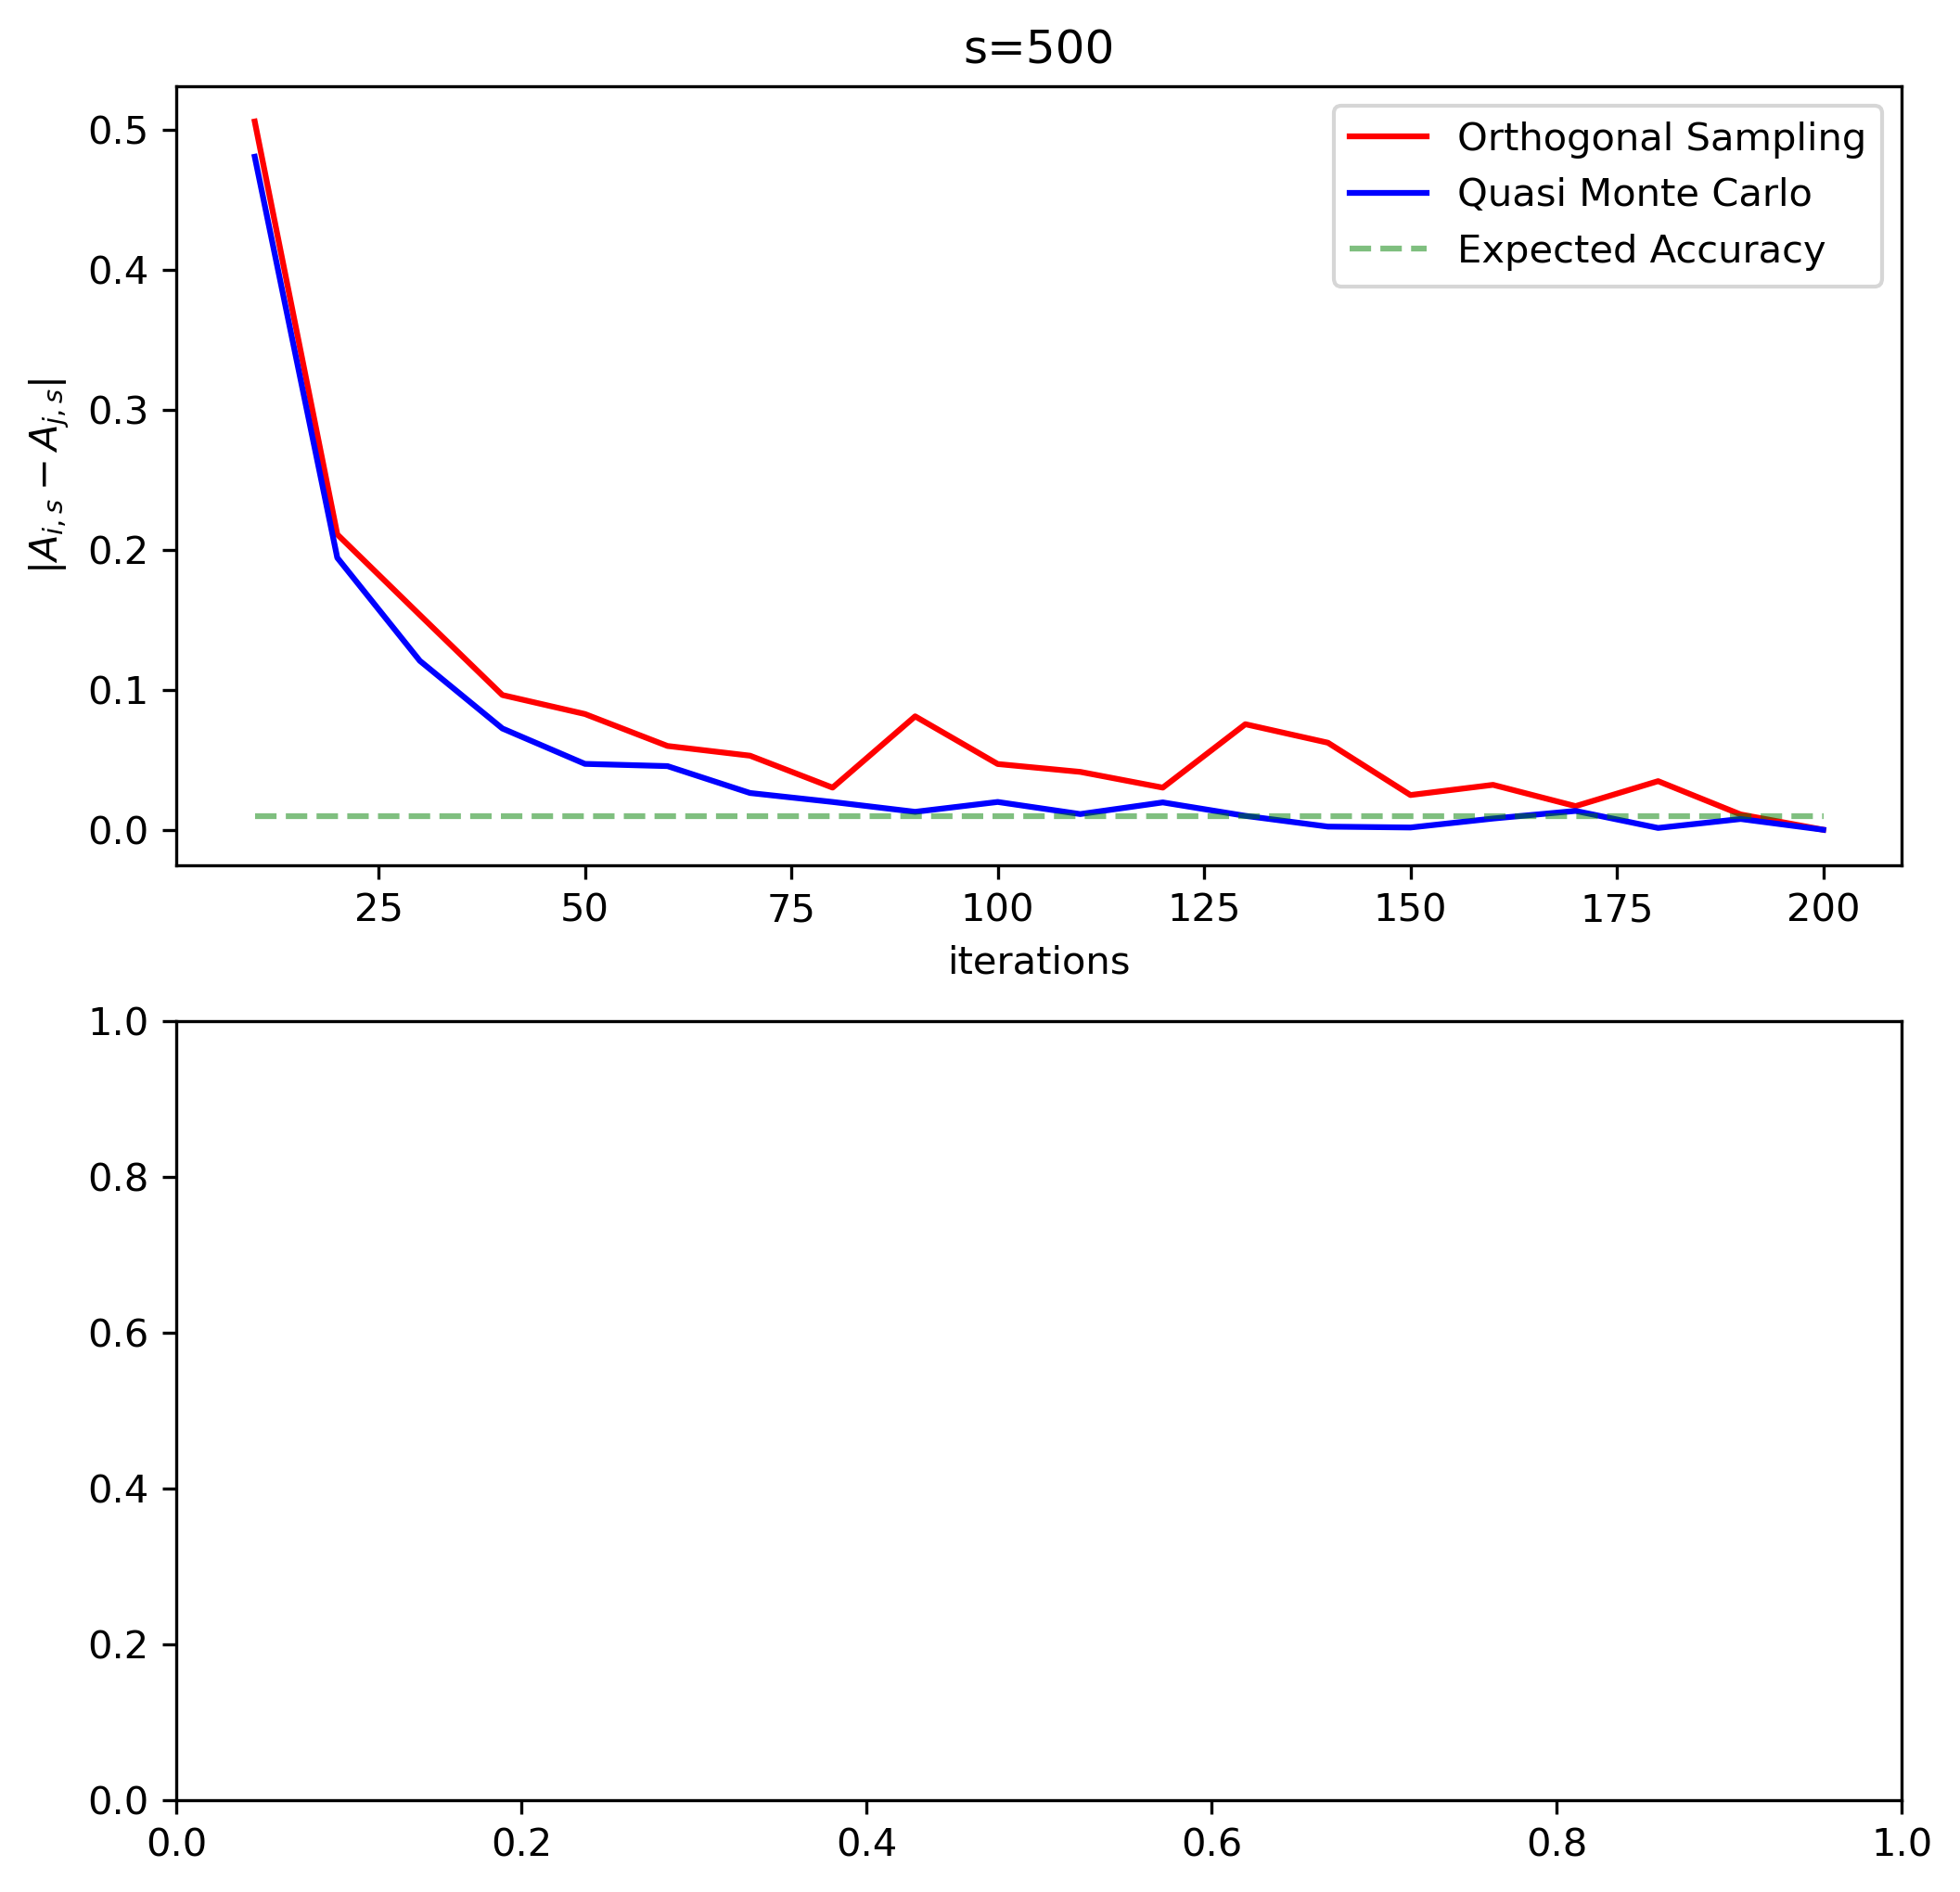

In [105]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(8, 8), dpi=300)
axes[0].set_title(f"Samples={s}")
axes[0].set_xlabel("Iterations")
axes[0].set_ylabel("$|A_{i,s}-A_{j,s}|$")
axes[0].plot(i_s, deltaA_OS, label='Orthogonal Sampling', c='r')
axes[0].plot(i_s, deltaA_QMC, label='Quasi Monte Carlo', c='b')
axes[0].hlines(expected_accuracy, i_start, i_end, linestyle='dashed', color="green", alpha=0.5, label='Expected Accuracy')
# axes[0].set_xlim(1, 50)
# axes[0].set_ylim(0, 0.1)
axes[0].legend()
# axes[1].set_xlabel("iterations")
# axes[1].set_ylabel("Standard Deviation")
# axes[1].plot(i_s, std_OS, label='Orthogonal Sampling', c='r')
# axes[1].plot(i_s, std_QMC, label='Sobol Sampling', c='b')
# axes[1].legend()
plt.show()

Compare sobol sequence with random sequence

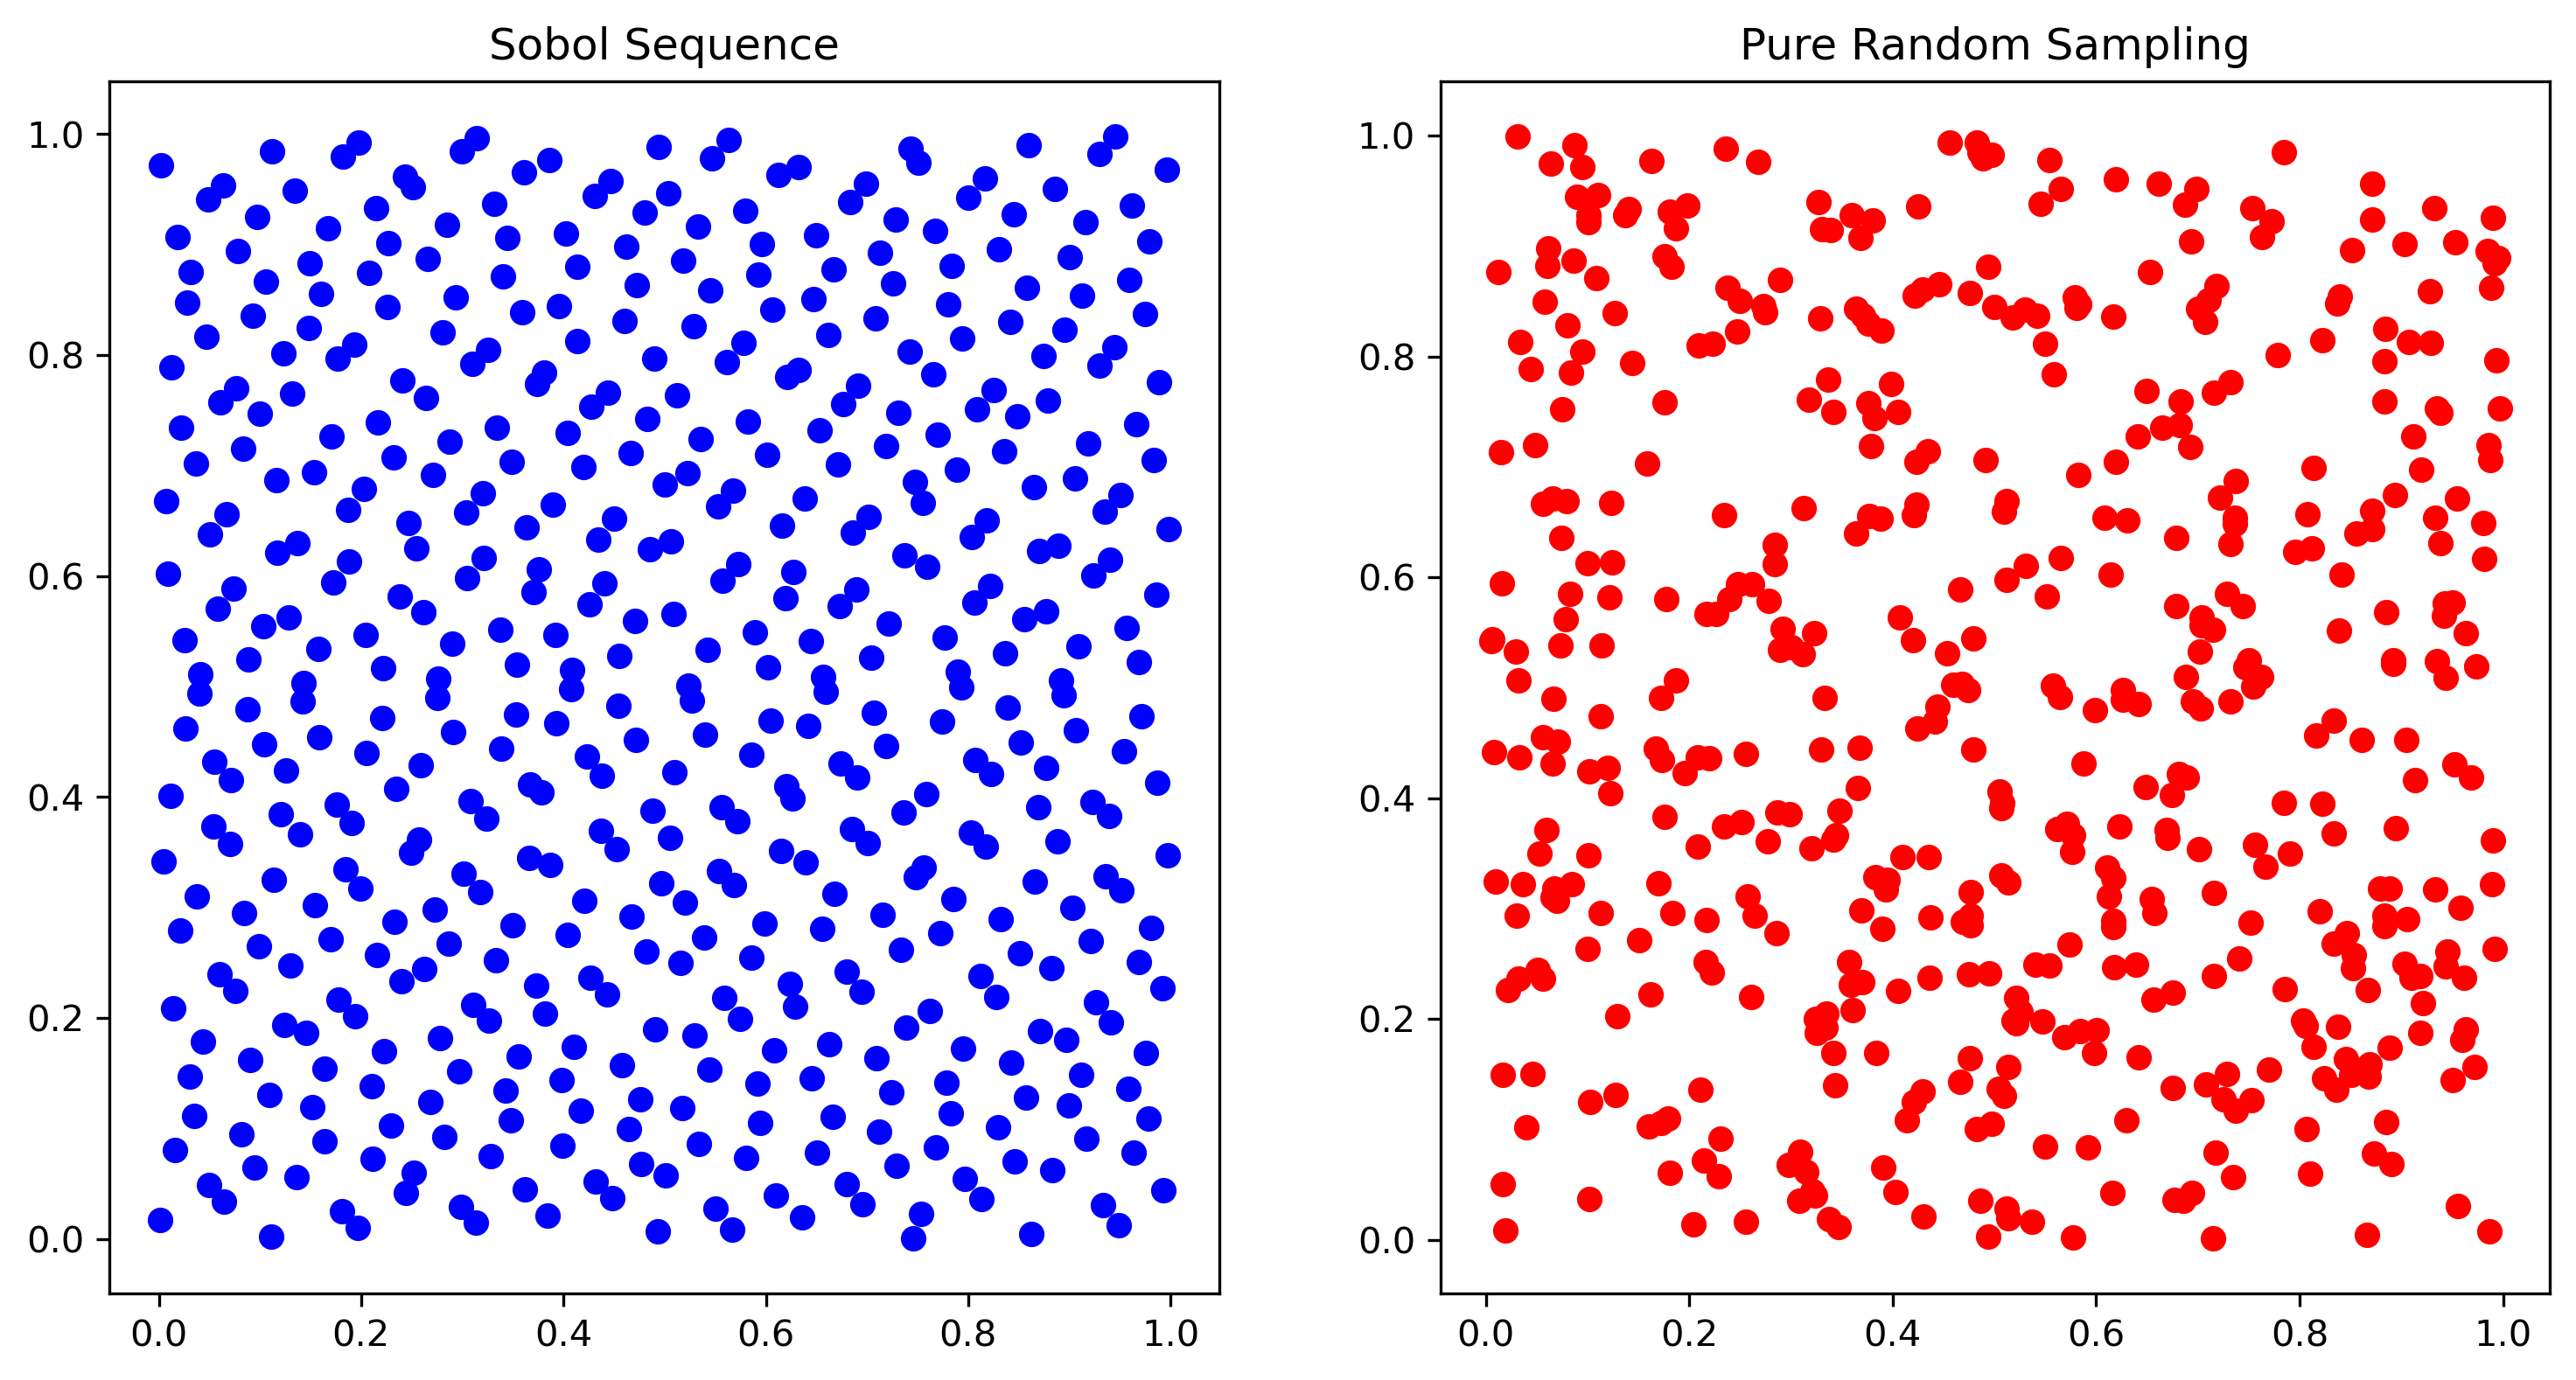

In [6]:
# 设置样本点的数量
n_samples = 512

# 生成Sobol序列样本点
sobol = qmc.Sobol(d=2)
sobol_samples = sobol.random(n=n_samples)

# 生成纯随机样本点
random_samples = np.random.rand(n_samples, 2)

# 绘制结果
plt.figure(figsize=(12, 6), dpi=300)

# 绘制Sobol序列生成的点
plt.subplot(1, 2, 1)
plt.scatter(sobol_samples[:, 0], sobol_samples[:, 1], color='blue')
plt.title("Sobol Sequence")

# 绘制纯随机生成的点
plt.subplot(1, 2, 2)
plt.scatter(random_samples[:, 0], random_samples[:, 1], color='red')
plt.title("Pure Random Sampling")

plt.show()